# CSCI 3022 Final Project - Regression
<figure>
  <IMG SRC="https://www.colorado.edu/cs/profiles/express/themes/cuspirit/logo.png" WIDTH=50 ALIGN="right">
</figure>

In [1]:
NAME = "Vu Dang"
COLLABORATORS = ""

In [45]:
%matplotlib inline
import numpy as np
import scipy as sp
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Set color map to have light blue background
sns.set()
import statsmodels.formula.api as smf
import statsmodels.api as sm
import patsy
import sklearn
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

## 1. Linear Regression 1

In this section, I will perform an initial pass through of loading, cleaning the data and finding an initial model through forward stepwise selection using the linear regression model.

In [31]:
# load in the data sets
data_test = pd.read_csv('test.csv', comment='#')
data_train = pd.read_csv('train.csv', comment='#')

The data has been loaded in. The first thing I will do is drop the "Id" column. I believe that this column is useless and should have no effect on the prediction of the sale price.

In [32]:
data_train = data_train.drop(["Id"], axis=1)
data_test = data_test.drop(["Id"], axis=1)
print(data_train)
print(data_test)

      MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0             60       RL         65.0     8450   Pave   NaN      Reg   
1             20       RL         80.0     9600   Pave   NaN      Reg   
2             60       RL         68.0    11250   Pave   NaN      IR1   
3             70       RL         60.0     9550   Pave   NaN      IR1   
4             60       RL         84.0    14260   Pave   NaN      IR1   
...          ...      ...          ...      ...    ...   ...      ...   
1455          60       RL         62.0     7917   Pave   NaN      Reg   
1456          20       RL         85.0    13175   Pave   NaN      Reg   
1457          70       RL         66.0     9042   Pave   NaN      Reg   
1458          20       RL         68.0     9717   Pave   NaN      Reg   
1459          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities LotConfig  ... PoolArea PoolQC  Fence MiscFeature  \
0            Lvl    AllPub    Inside  ...  

I notice that there are lots of NaNs in both the test and train data. For this section, I will naively fill any numerical NaNs with 0's. In the next section I will perform a more educated cleaning procedure.

In [33]:
data_train = data_train.fillna(0.0)
data_test = data_test.fillna(0.0)
print(data_train.info())
print(data_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

The NaNs have been filled with 0s. Now, I'm going to rename some columns, purely due to the fact that the statsmodel library doesn't like variable names with numerical digits as prefixes. As you can see, I'm simply replacing the bad variable names with the working ones. 

In [34]:
data_train.rename(columns={'1stFlrSF':'FirstFlrSF'}, inplace=True)
data_train.rename(columns={'2ndFlrSF':'SecondFlrSF'}, inplace=True)
data_train.rename(columns={'3SsnPorch':'ThreeSsnPorch'}, inplace=True)

data_test.rename(columns={'1stFlrSF':'FirstFlrSF'}, inplace=True)
data_test.rename(columns={'2ndFlrSF':'SecondFlrSF'}, inplace=True)
data_test.rename(columns={'3SsnPorch':'ThreeSsnPorch'}, inplace=True)

In this next part, I'm setting up the prerequisites for performing forward stepwise selection. In a nutshell, what I'm trying to do is create a vector of what I think are useful variables. In this case, useful variables are variables that are non-categorical. As you can see in the code and the resulting print results, I'm only keeping variables that have numbers.

In [80]:


# get the list of columns
# this is the list of potential variables
cols = list(data_train.columns)
# drop "SalePrice" from this list because it's the variable we're trying to predict
cols.remove("SalePrice")

print(cols)
print(len(cols))

to_remove = []
for var in cols:
    if data_train[var].dtypes == "object":
        to_remove.append(var)
        
for elem in to_remove:
    cols.remove(elem)

print(cols)
print(len(cols))


['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'FirstFlrSF', 'SecondFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ThreeSsnPorch', 'ScreenPorch', 'PoolArea', 'Pool

The good thing about forward selection is that it doesn't really matter how the variables correlate with one another. Simply iterating through all of them will eventually land on the "best" model. Since there are 36 variables that I want to keep, there will be 36 "best" models generated, one for each "number of variables". Then, I will plot the R^2 score for each model.

Text(0, 0.5, 'R^2')

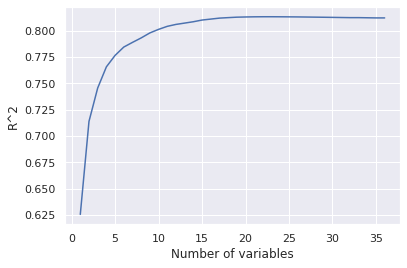

In [36]:
# forward selection implementation

# a list of the best smf.ols object created for each model
m_list = []
# k is the number of possible factors
k = len(cols)
# a list of the best r score for each k, using the training set 
r_train_list = []
# a list of the best r score for each k, using the test set 
r_test_list = []
# a list of the best model for each k
model_list = []
# allowed factors
allowed_factors = cols
# initialize the first model
m_k = smf.ols("SalePrice ~ MSSubClass", data=data_train).fit()
model = "SalePrice ~ "
for i in range(k):
    # loop through the allowed factors
    if (i > 0):
        model_temp = model + allowed_factors[0]
        m_k = smf.ols(model_temp, data=data_train).fit()
    for factor in allowed_factors:
        # create the string representing the model
        model_temp = model + factor
        #print(model_temp)
        # fit the model
        m = smf.ols(model_temp, data=data_train).fit()
        # if the r^2 score of the temporary model is higher than that of the baseline model
        # then update the baseline model to the temporary model
        # also update the best_model variable to reflect the current best model
        # and also record the factor that was chosen
        if (m.rsquared_adj >= m_k.rsquared_adj):
            m_k = m
            best_model_mk = model_temp
            chosen_factor = factor
    model = best_model_mk + " + "
    model_list.append(model)
    m_list.append(m_k)
    allowed_factors.remove(chosen_factor)
    r_train_list.append(m_k.rsquared_adj)

x = range(1, len(r_train_list)+1)
plt.plot(x, r_train_list)
plt.xlabel("Number of variables")
plt.ylabel("R^2")

The forward selection process is now finished. To find the best model, I simply need to find the index at which the R^2 score was the highest in the $r_train_list$ vector. This can be accomplished using the np.argmax() function. Once this is done, I can use this index and print out the best model selection and also use the model to predict the sale prices from the test dataset. 

In [63]:
max_idx = np.argmax(r_train_list)
best_model = m_list[max_idx]
print(f"The best model is {model_list[max_idx]}")
print(f"This model uses {max_idx+1} variables.")
print(f"This model has an R^2 of {r_train_list[max_idx]}.")
predict_price = best_model.predict(data_test)
print(predict_price)

best_linear_regression_1_model = model_list[max_idx]

The best model is SalePrice ~ OverallQual + GrLivArea + BsmtFinSF1 + GarageCars + MSSubClass + YearBuilt + BedroomAbvGr + OverallCond + GarageYrBlt + LotArea + MasVnrArea + BsmtFullBath + TotRmsAbvGrd + ScreenPorch + WoodDeckSF + KitchenAbvGr + TotalBsmtSF + Fireplaces + YearRemodAdd + FullBath + LowQualFinSF + PoolArea + YrSold + 
This model uses 23 variables.
This model has an R^2 of 0.8131253479855177.
0       116762.584782
1       160461.401492
2       173429.464588
3       200721.259106
4       195038.498874
            ...      
1454     75531.691530
1455     61551.235844
1456    178515.338047
1457    116506.028507
1458    258825.504074
Length: 1459, dtype: float64


The R^2 for this model is around 0.8, which is not bad! However, this model doesn't account for the interactions between the variables and the NaNs were filled in very naively. In the next section, I will be making improvements for the data clean up process, which I think will help a lot.

## 2. Linear Regression 2

The first step to improving the data cleanup process is by filling NaNs with values that actually make sense. To keep things simple, I will fill NaNs with the average* value of each column. If the column is a floating point column, NaNs will be filled with the "true" average, otherwise they will be filled with a rounded version of the avergage.

To start fresh, I will load back in the data sets and drop the "Id" column as before.

In [19]:
# load in the data sets
data_test = pd.read_csv('test.csv', comment='#')
data_train = pd.read_csv('train.csv', comment='#')

In [20]:
data_train = data_train.drop(["Id"], axis=1)
data_test = data_test.drop(["Id"], axis=1)
print(data_test.info())
print(data_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1459 non-null   int64  
 1   MSZoning       1455 non-null   object 
 2   LotFrontage    1232 non-null   float64
 3   LotArea        1459 non-null   int64  
 4   Street         1459 non-null   object 
 5   Alley          107 non-null    object 
 6   LotShape       1459 non-null   object 
 7   LandContour    1459 non-null   object 
 8   Utilities      1457 non-null   object 
 9   LotConfig      1459 non-null   object 
 10  LandSlope      1459 non-null   object 
 11  Neighborhood   1459 non-null   object 
 12  Condition1     1459 non-null   object 
 13  Condition2     1459 non-null   object 
 14  BldgType       1459 non-null   object 
 15  HouseStyle     1459 non-null   object 
 16  OverallQual    1459 non-null   int64  
 17  OverallCond    1459 non-null   int64  
 18  YearBuil

In [21]:
# fill NaNs for non-object variables only.

for col in data_train.columns:
    if (data_train[col].dtypes != "object"):
        avg = data_train[col].mean()
        data_train[col] = data_train[col].fillna(avg)

for col in data_test.columns:
    if (data_test[col].dtypes != "object"):
        avg = data_test[col].mean()
        data_test[col] = data_test[col].fillna(avg)

In [22]:
print(data_train.info())
print(data_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

Now that the cleanup part is over, I will create a pairplot of the data and look for any relationships between the variables. In order to do this, I will first reduce the data set by dropping the categorical variables again.

In [23]:
# Renaming some columns too
data_train.rename(columns={'1stFlrSF':'FirstFlrSF'}, inplace=True)
data_train.rename(columns={'2ndFlrSF':'SecondFlrSF'}, inplace=True)
data_train.rename(columns={'3SsnPorch':'ThreeSsnPorch'}, inplace=True)

data_test.rename(columns={'1stFlrSF':'FirstFlrSF'}, inplace=True)
data_test.rename(columns={'2ndFlrSF':'SecondFlrSF'}, inplace=True)
data_test.rename(columns={'3SsnPorch':'ThreeSsnPorch'}, inplace=True)

In [53]:
# get the list of columns
# this is the list of potential variables
cols = list(data_train.columns)
# drop "SalePrice" from this list because it's the variable we're trying to predict
cols.remove("SalePrice")

print(cols)
print(len(cols))

to_remove = []
for var in cols:
    if data_train[var].dtypes == "object":
        to_remove.append(var)
        
for elem in to_remove:
    cols.remove(elem)

print(cols)
print(len(cols))


['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'FirstFlrSF', 'SecondFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ThreeSsnPorch', 'ScreenPorch', 'PoolArea', 'Pool

Now that I have a list of allowed variables, I will reduce the size of the DataFrame to only include the allowed variables. 

In [25]:
data_test = data_test[cols]
cols.append("SalePrice")
data_train = data_train[cols]

In [26]:
# drop SalePrice from the list again
cols.remove("SalePrice")

There are 36 variables. A pairplot would need to create 36^2 = 1296 plots. It would take a very long time to finish. So instead of doing that, I'll create 36 pairplots, each with 6 randomly chosen variables. That shouldn't take as long. I couldn't figure out how to create multiple different pairplots so I'll just create 1.

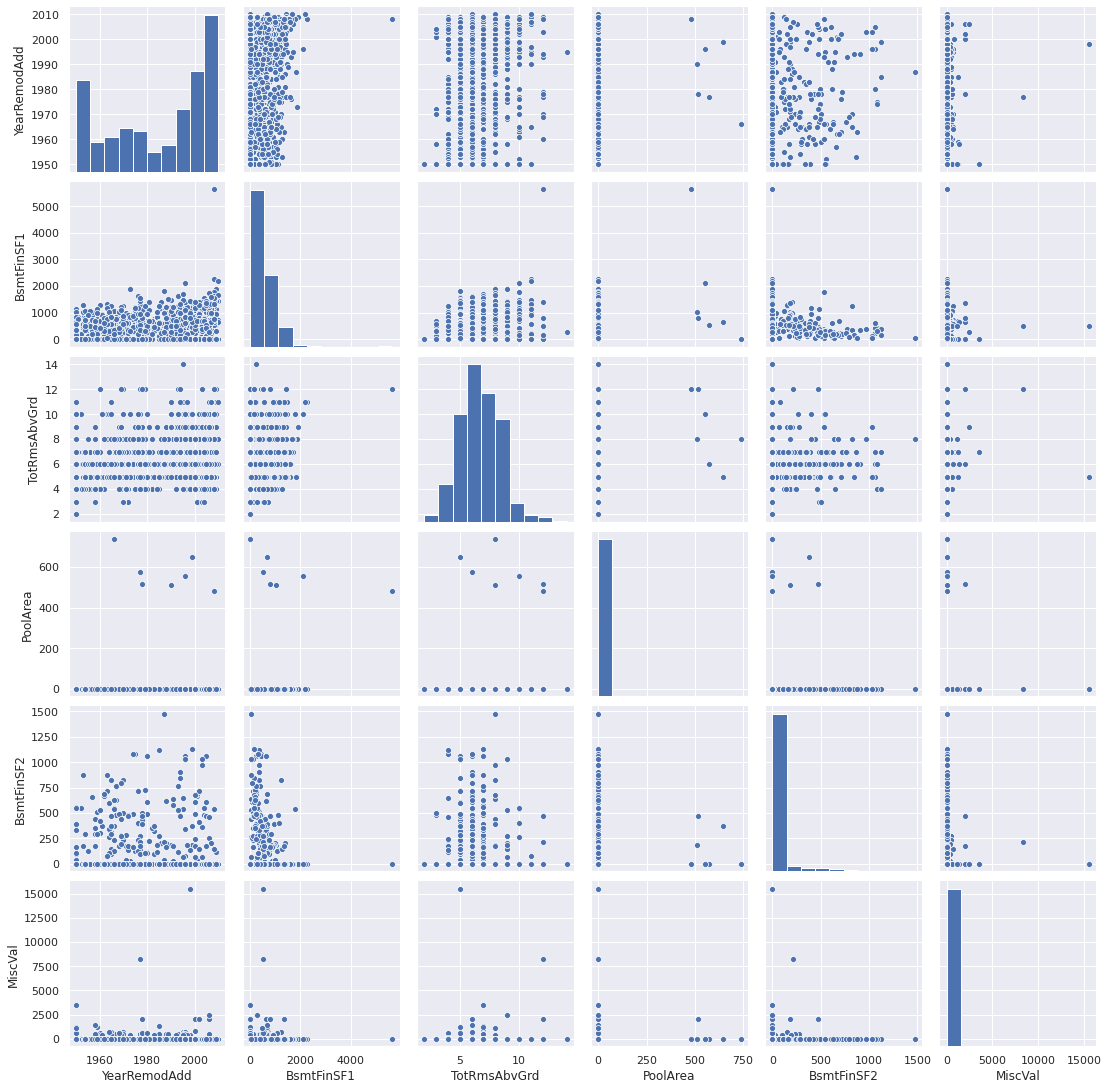

In [27]:
# 1
random_vars = np.random.choice(cols, 6)
small_set = data_train[random_vars]
sns.pairplot(small_set)


There doesn't realy seem to be any correlations between the 6 randomly chosen variables, but the way the plots look make me feel like a logistic regression might give really good results. So, I'll explore that in the next section. For now, I will keep going forward with linear regression. The code is the same as in Section 1. A plot of the R^2 score is included and the model is also included.

Text(0, 0.5, 'R^2')

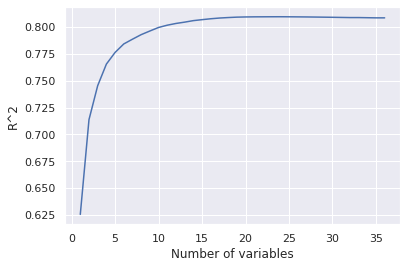

In [28]:
# forward selection implementation

# a list of the best smf.ols object created for each model
m_list = []
# k is the number of possible factors
k = len(cols)
# a list of the best r score for each k, using the training set 
r_train_list = []
# a list of the best r score for each k, using the test set 
r_test_list = []
# a list of the best model for each k
model_list = []
# allowed factors
allowed_factors = cols
# initialize the first model
m_k = smf.ols("SalePrice ~ MSSubClass", data=data_train).fit()
model = "SalePrice ~ "
for i in range(k):
    # loop through the allowed factors
    if (i > 0):
        model_temp = model + allowed_factors[0]
        m_k = smf.ols(model_temp, data=data_train).fit()
    for factor in allowed_factors:
        # create the string representing the model
        model_temp = model + factor
        #print(model_temp)
        # fit the model
        m = smf.ols(model_temp, data=data_train).fit()
        # if the r^2 score of the temporary model is higher than that of the baseline model
        # then update the baseline model to the temporary model
        # also update the best_model variable to reflect the current best model
        # and also record the factor that was chosen
        if (m.rsquared_adj >= m_k.rsquared_adj):
            m_k = m
            best_model_mk = model_temp
            chosen_factor = factor
    model = best_model_mk + " + "
    model_list.append(model)
    m_list.append(m_k)
    allowed_factors.remove(chosen_factor)
    r_train_list.append(m_k.rsquared_adj)

x = range(1, len(r_train_list)+1)
plt.plot(x, r_train_list)
plt.xlabel("Number of variables")
plt.ylabel("R^2")

In [29]:
max_idx = np.argmax(r_train_list)
best_model = m_list[max_idx]
print(f"The best model is {model_list[max_idx]}")
print(f"This model uses {max_idx+1} variables.")
print(f"This model has an R^2 of {r_train_list[max_idx]}.")


predict_price = best_model.predict(data_test)
print(predict_price)

The best model is SalePrice ~ OverallQual + GrLivArea + BsmtFinSF1 + GarageCars + MSSubClass + YearBuilt + BedroomAbvGr + OverallCond + LotArea + MasVnrArea + BsmtFullBath + TotRmsAbvGrd + WoodDeckSF + ScreenPorch + TotalBsmtSF + YearRemodAdd + KitchenAbvGr + Fireplaces + FullBath + GarageYrBlt + PoolArea + YrSold + LowQualFinSF + LotFrontage + 
This model uses 24 variables.
This model has an R^2 of 0.8097002534319625.
0       118504.813973
1       163042.668599
2       173608.497914
3       200027.557758
4       195343.381853
            ...      
1454     58924.834755
1455     66808.129661
1456    171623.264178
1457     98969.768138
1458    253322.571866
Length: 1459, dtype: float64


Well the results are surprising! Using the average value results in a worse best R^2 score and more variables had to be used. So, moving on to the next section, perhaps using a logistic regression might yield better results.

## 3. Logistic Regression

In this section, instead of using forward selection to pick my model, I will use all 36 variables. I will also clean and format the data the same way as in Section 1.

In [81]:
# load in the data sets
data_test = pd.read_csv('test.csv', comment='#')
data_train = pd.read_csv('train.csv', comment='#')
data_train = data_train.drop(["Id"], axis=1)
data_test = data_test.drop(["Id"], axis=1)
data_train = data_train.fillna(0.0)
data_test = data_test.fillna(0.0)
data_train.rename(columns={'1stFlrSF':'FirstFlrSF'}, inplace=True)
data_train.rename(columns={'2ndFlrSF':'SecondFlrSF'}, inplace=True)
data_train.rename(columns={'3SsnPorch':'ThreeSsnPorch'}, inplace=True)
data_test.rename(columns={'1stFlrSF':'FirstFlrSF'}, inplace=True)
data_test.rename(columns={'2ndFlrSF':'SecondFlrSF'}, inplace=True)
data_test.rename(columns={'3SsnPorch':'ThreeSsnPorch'}, inplace=True)

Let's get rid of all the "object" columns.

In [82]:
cols.append("SalePrice")
data_train_new = data_train[cols]
cols.remove("SalePrice")
data_test_new = data_test[cols]

In [85]:
model = "SalePrice ~ "
for i in range(len(cols)):
    if (i != (len(cols)-1)):
        model += cols[i] + " + "
    else:
        model += cols[i]
print(model)
lr = sklearn.linear_model.LogisticRegression()
y,X = patsy.dmatrices(model, data=data_train_new)
log_reg_model_full = lr.fit(X, y.ravel())
print('Score is', log_reg_model_full.score(X, y.ravel()))

SalePrice ~ MSSubClass + LotFrontage + LotArea + OverallQual + OverallCond + YearBuilt + YearRemodAdd + MasVnrArea + BsmtFinSF1 + BsmtFinSF2 + BsmtUnfSF + TotalBsmtSF + FirstFlrSF + SecondFlrSF + LowQualFinSF + GrLivArea + BsmtFullBath + BsmtHalfBath + FullBath + HalfBath + BedroomAbvGr + KitchenAbvGr + TotRmsAbvGrd + Fireplaces + GarageYrBlt + GarageCars + GarageArea + WoodDeckSF + OpenPorchSF + EnclosedPorch + ThreeSsnPorch + ScreenPorch + PoolArea + MiscVal + MoSold + YrSold
Score is 0.05342465753424658


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Wow...The result is very disappointing here. It seems like logistic regression is the wrong way to go here! Or perhaps my code is wrong somehow.

## 4. Results Discussion

# a. Linear Regression
<br>
It definitely seems that linear regression was the way to go for this project. The initial "naive" way of cleaning up the data and using forward selection to algorithmically select variables proved to be the best way to predict the housing prices. The best R^2 score was around 0.831. When trying to improve the data clean up process by filling in NaNs with the average value of each column, the R^2 score went down. This was a very surprising result since I thought that having more realistic values would improve prediction results. 
<br>

# b. Logistic Regression
<br>
The result here was extremely disappointing, to say the least. Some of the variables looked like they could do very well with a logistic regression model. However, the end result was a score of 0.0534. That indicates extremely poor fit.
<br>
To recap, here are the best prediction scores for:
<br>
Linear Regression with 0's for NaNs : 0.831
<br>
Linear Regression with average for NaNs: 0.8097
<br>
Logistic Regression with all variables: 0.0534

## 5. Conclusion

To recap, linear regression using forward regression and filling NaNs with 0's was the best method for obtaining a decent prediction model. The best model used 23 out of 36 numerical variables. However, there are 79 variables in total that could have been used. 
<br>
I think a few of the categorical variables could be used to improve prediction results. For example, whether or not a house has a garage should definitely influence the price of a house. Furthermore, there should be some interactions between whether or not there is a garage and the size of the garage. A larger garage should mean a higher sale price! In order to turn these categorical variables into numerical variables, numerical values must be assigned to them. The variable that describes whether or not there is a garage could be represented by a boolean. I didn't do this because the description of said variable included more than 2 choices. There are other categorical variables that are the same way, i.e. they have more than 2 values. To fully clean up and prepare the data, a full understanding of the data set, which includes understanding the values that each variable represents and assigning numerical values as appropriate. It would be great to be able to see a full pairplot of all 79 variables. The interactions between variables would be fully shown then.
<br>
I'm not sure how the logistic regression model could be improved. Perhaps logistic regression is out of the question for this data set.